# Computer Vision 2022 Assignment 2: Image matching and retrieval

In this assignment, you will experiment with image feature detectors, descriptors and matching. There are 3 main parts to the assignment:

- matching an object in a pair of images
- searching for an object in a collection of images
- analysis and discussion of results

This assignment will have a minimum hurdle of 40%. You will fail if you can not reach the minimum hurdle.

## General instructions

As before, you will use this notebook to run your code and display your results and analysis. Again we will mark a PDF conversion of your notebook, referring to your code if necessary, so you should ensure your code output is formatted neatly. 

***When converting to PDF, include the outputs and analysis only, not your code.*** You can do this from the command line using the `nbconvert` command (installed as part of Jupyter) as follows:

    jupyter nbconvert Assignment2.ipynb --to pdf --no-input --TagRemovePreprocessor.remove_cell_tags 'remove-cell'
    # Or
    jupyter nbconvert Assignment2.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}'

**Please do try this ccommond early before the last day! As the commend may be a little bit difference depending on your computer and the environment.**

This will also remove the preamble text from each question. We will use the `OpenCV` library to complete the prac. It has several built in functions that will be useful. You are expected to consult documentation and use them appropriately.

This being the second assignment, we have provided less strict direction this time and you have more flexibility to choose how you answer each question. However you still need to ensure the outputs and report are clear and easy to read. This includes:

- sizing, arranging and captioning image outputs appropriately
- explaining what you have done clearly and concisely
- clearly separating answers to each question

## Data

We have provided some example images for this assignment, available through a link on the MyUni assignment page. The images are organised by subject matter, with one folder containing images of book covers, one of museum exhibits, and another of urban landmarks. Within each category, there is a “Reference” folder containing a clean image of each object and a “Query” folder containing images taken on a mobile device. Within each category, images with the same name contain the same object (so 001.jpg in the Reference folder contains the same book as 001.jpg in the Query folder).
The data is a subset of the Stanford Mobile Visual Search Dataset which is available at 

<http://web.cs.wpi.edu/~claypool/mmsys-dataset/2011/stanford/index.html>. 

The full data set contains more image categories and more query images of the objects we have provided, which may be useful for your testing!

Do not submit your own copy of the data or rename any files or folders! For marking, we will assume the datasets are available in subfolders of the working directory using the same folder names provided.

Here is some general setup code, which you can edit to suit your needs.

In [120]:
# Numpy is the main package for scientific computing with Python.
import numpy as np
import cv2

# Matplotlib is a useful plotting library for python 
import matplotlib.pyplot as plt
# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
% matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots, can be changed
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
% load_ext autoreload
% autoreload 2
% reload_ext autoreload

UsageError: Line magic function `%` not found.


In [121]:
def draw_outline (ref, query, model):
    """
        Draw outline of reference image in the query image.
        This is just an example to show the steps involved.
        You can modify to suit your needs.
        Inputs:
            ref: reference image
            query: query image
            model: estimated transformation from query to reference image
    """
    h, w = ref.shape[:2]
    pts = np.float32 ([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape (-1, 1, 2)
    dst = cv2.perspectiveTransform (pts, model)

    img = query.copy ()
    img = cv2.polylines (img, [np.int32 (dst)], True, 255, 10, cv2.LINE_AA)
    plt.imshow (img, 'gray'), plt.show ()


def draw_inliers (img1, img2, kp1, kp2, matches, matchesMask):
    """
        Draw inlier between images
        img1 / img2: reference/query  img
        kp1 / kp2: their keypoints
        matches : list of (good) matches after ratio test
        matchesMask: Inlier mask returned in cv2.findHomography() 
    """
    matchesMask = matchesMask.ravel ().tolist ()
    draw_params = dict (
            matchColor=(0, 255, 0),  # draw matches in green color
            singlePointColor=None,
            matchesMask=matchesMask,  # draw only inliers
            flags=2
            )
    img3 = cv2.drawMatches (img1, kp1, img2, kp2, matches, None, **draw_params)
    plt.imshow (img3, 'gray'), plt.show ()


# Question 1: Matching an object in a pair of images (45%)

In this question, the aim is to accurately locate a reference object in a query image, for example:


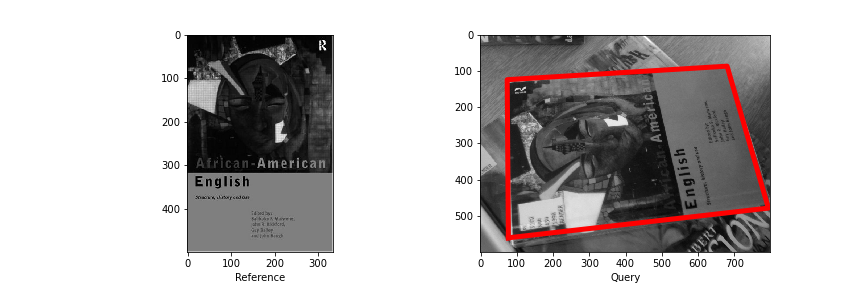

0. Download and read through the paper [ORB: an efficient alternative to SIFT or SURF](https://www.researchgate.net/publication/221111151_ORB_an_efficient_alternative_to_SIFT_or_SURF) by Rublee et al. You don't need to understand all the details, but try to get an idea of how it works. ORB combines the FAST corner detector (covered in week 4) and the BRIEF descriptor. BRIEF is based on similar ideas to the SIFT descriptor we covered week 4, but with some changes for efficiency.

1. [Load images] Load the first (reference, query) image pair from the "book_covers" category using opencv (e.g. `img=cv2.imread()`). Check the parameter option in "
cv2.imread()" to ensure that you read the gray scale image, since it is necessary for computing ORB features.

2. [Detect features] Create opencv ORB feature extractor by `orb=cv2.ORB_create()`. Then you can detect keypoints by `kp = orb.detect(img,None)`, and compute descriptors by `kp, des = orb.compute(img, kp)`. You need to do this for each image, and then you can use `cv2.drawKeypoints()` for visualization.

3. [Match features] As ORB is a binary feature, you need to use HAMMING distance for matching, e.g., `bf = cv2.BFMatcher(cv2.NORM_HAMMING)`. Then you are requried to do KNN matching (k=2) by using `bf.knnMatch()`. After that, you are required to use "ratio_test" to find good matches. By default, you can set `ratio=0.8`.

4. [Plot and analyze] You need to visualize the matches by using the `cv2.drawMatches()` function. Also you can change the ratio values, parameters in `cv2.ORB_create()`, and distance functions in `cv2.BFMatcher()`. Please discuss how these changes influence the match numbers.


In [122]:
# Your code for descriptor matching tests here

# load image at gray scale
def MY_ORB (path, image, print_img =True):
    image_Query = cv2.imread (f'./A2_smvs/'+ path + '/Query/' + image + '.jpg', cv2.IMREAD_GRAYSCALE)
    image_Reference = cv2.imread ('./A2_smvs/' + path + '/Reference/' + image + '.jpg', cv2.IMREAD_GRAYSCALE)

    # compute detector and descriptor
    # 创建ORB特征提取器
    orb = cv2.ORB_create ()

    # find the keypoints and descriptors with ORB
    # 检测关键点
    kp1 = orb.detect (image_Reference, None)
    kp2 = orb.detect (image_Query, None)
    # 计算描述符
    kp1, des1 = orb.compute (image_Reference, kp1)
    kp2, des2 = orb.compute (image_Query, kp2)

    # draw keypoints
    # 对关键点进行可视化
    image_Reference_orb = cv2.drawKeypoints (image_Reference, kp1, None, color=(0, 255, 0), flags=0)
    image_Query_orb = cv2.drawKeypoints (image_Query, kp2, None, color=(0, 255, 0), flags=0)

    # create BFMatcher object
    bf = cv2.BFMatcher (cv2.NORM_HAMMING, crossCheck=False)

    # Match descriptors.
    matches = bf.knnMatch (des1, des2, k=2)

    # Apply ratio test
    # 筛选匹配项(ratio_test,ratio=0.8)
    # 创建子集，并以list的形式存入(一个只包含一个值的list)
    good_match = []
    # 创建子集合，但不创建list
    good_without_list = []
    for (x, y) in matches:
        if x.distance < 0.8 * y.distance:
            good_match.append ([x])
            good_without_list.append (x)

    # draw matches
    result = cv2.drawMatchesKnn (image_Reference, kp1, image_Query, kp2, good_match, outImg=None, flags=2)
    if print_img:
        plt.subplot (221)
        plt.imshow (image_Reference_orb)
        plt.subplot (222)
        plt.imshow (image_Query_orb)
        plt.subplot (212)
        plt.imshow (result)
        plt.show ()

    return [image_Query, image_Reference, kp1, des1, kp2, des2, matches, good_match, good_without_list]

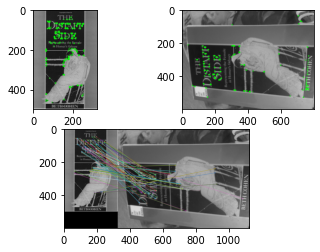

In [123]:
image_Query, image_Reference, kp1, des1, kp2, des2, matches, good_match, good_without_list = MY_ORB ('book_covers','001')

***Your explanation of what you have done, and your results, here***

3. Estimate a homography transformation based on the matches, using `cv2.findHomography()`. Display the transformed outline of the first reference book cover image on the query image, to see how well they match.

    - We provide a function `draw_outline()` to help with the display, but you may need to edit it for your needs.
    - Try the 'least squre method' option to compute homography, and visualize the inliers by using `cv2.drawMatches()`. Explain your results.
    - Again, you don't need to compare results numerically at this stage. Comment on what you observe visually.

In [124]:
def findHomography (image_1_kp, image_2_kp, good_matches, is_RANSAC=False):
    image_1_points = np.zeros ((len (good_matches), 1, 2), dtype=np.float32)
    image_2_points = np.zeros ((len (good_matches), 1, 2), dtype=np.float32)

    for i in range (0, len (good_matches)):
        image_1_points[i] = image_1_kp[good_matches[i].queryIdx].pt
        image_2_points[i] = image_2_kp[good_matches[i].trainIdx].pt

    if is_RANSAC:
        M, Mask = cv2.findHomography (image_1_points, image_2_points, cv2.RANSAC, ransacReprojThreshold=2.0)
    else:
        M, Mask = cv2.findHomography (image_1_points, image_2_points, ransacReprojThreshold=2.0)

    return [M, Mask]

In [125]:
def outline_inliers(path,image,is_RANSAC = False):
    image_Query, image_Reference, kp1, des1, kp2, des2, matches, good_match, good_without_list = MY_ORB(path,image,print_img=False)

    # using regular method (cv2.findHomography)
    M, Mask = findHomography (kp1, kp2, good_without_list, is_RANSAC)
    # draw outline
    plt.subplot(121)
    draw_outline (image_Reference, image_Query, M)
    # draw inliers
    draw_inliers (image_Reference, image_Query, kp1, kp2, good_without_list, Mask)

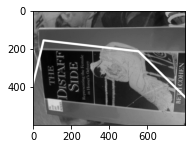

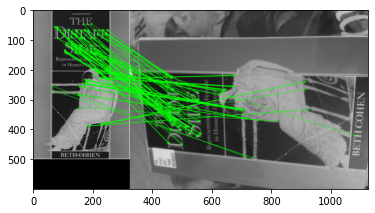

In [126]:
# Your code to display book location here
outline_inliers('book_covers','001',False)

***Your explanation of results here***

Try the RANSAC option to compute homography. Change the RANSAC parameters, and explain your results. Print and analyze the inlier numbers. Hint: use cv2.RANSCA with cv2.findHomography.


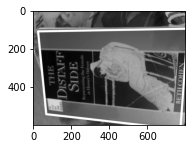

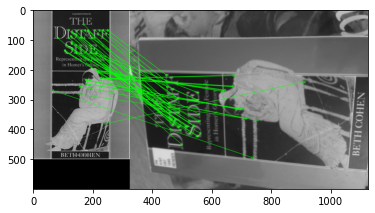

In [127]:
# Your code to display book location after RANSAC here
outline_inliers('book_covers','001',True)

***Your explanation of what you have tried, and results here***

6. Finally, try matching several different image pairs from the data provided, including at least one success and one failure case. For the failure case, test and explain what step in the feature matching has failed, and try to improve it. Display and discuss your findings.
    1. Hint 1: In general, the book covers should be the easiest to match, while the landmarks are the hardest.
    2. Hint 2: Explain why you chose each example shown, and what parameter settings were used.
    3. Hint 3: Possible failure points include the feature detector, the feature descriptor, the matching strategy, or a combination of these.

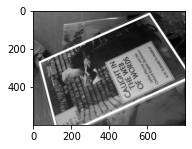

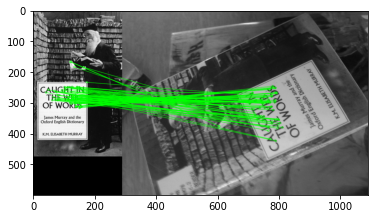

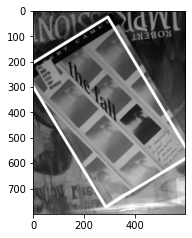

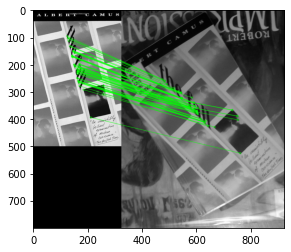

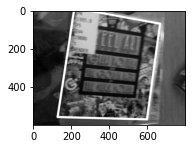

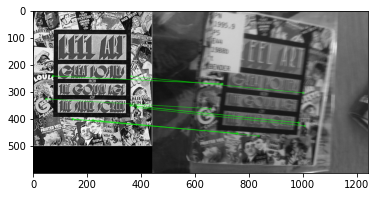

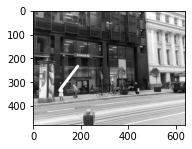

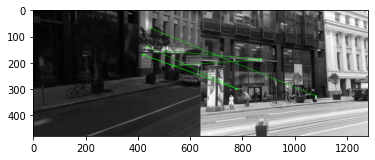

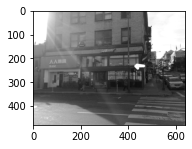

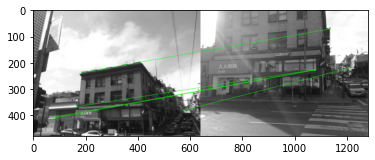

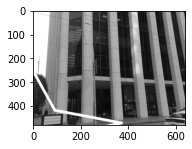

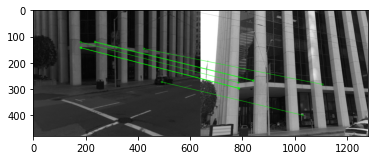

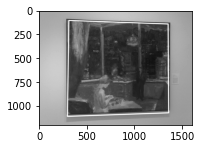

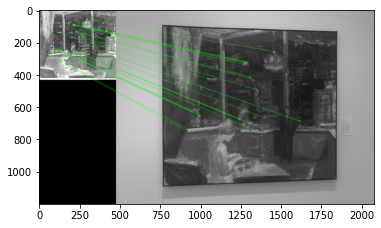

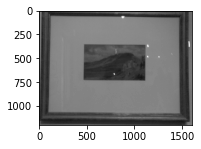

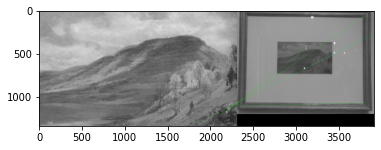

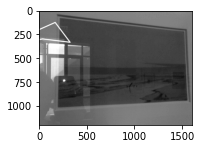

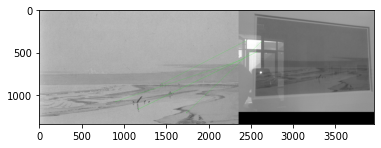

In [128]:
# Your results for other image pairs here
outline_inliers('book_covers','010',True)
outline_inliers('book_covers','030',True)
outline_inliers('book_covers','050',True)

outline_inliers('landmarks','010',True)
outline_inliers('landmarks','030',True)
outline_inliers('landmarks','050',True)

outline_inliers('museum_paintings','010',True)
outline_inliers('museum_paintings','030',True)
outline_inliers('museum_paintings','050',True)

***Your explanation of results here***

# Question 2: What am I looking at? (40%)


<!--One application of feature matching is image retrieval. The goal of image retrieval is, given a query image of an object, to find all images in a database containing the same object, and return the results in ranked order (like a Google search). This is a huge research area but we will implement a very basic version of the problem based on the small dataset provided.-->

In this question, the aim is to identify an "unknown" object depicted in a query image, by matching it to multiple reference images, and selecting the highest scoring match. Since we only have one reference image per object, there is at most one correct answer. This is useful for example if you want to automatically identify a book from a picture of its cover, or a painting or a geographic location from an unlabelled photograph of it.

The steps are as follows:

1. Select a set of reference images and their corresponding query images. 

    1. Hint 1: Start with the book covers, or just a subset of them.
    3. Hing 2: This question can require a lot of computation to run from start to finish, so cache intermediate results (e.g. feature descriptors) where you can.
    
2. Choose one query image corresponding to one of your reference images. Use RANSAC to match your query image to each reference image, and count the number of inlier matches found in each case. This will be the matching score for that image.

3. Identify the query object. This is the identity of the reference image with the highest match score, or "not in dataset" if the maximum score is below a threshold.

4. Repeat steps 2-3 for every query image and report the overall accuracy of your method (that is, the percentage of query images that were correctly matched in the dataset). Discussion of results should include both overall accuracy and individual failure cases.

    1. Hint 1: In case of failure, what ranking did the actual match receive? If we used a "top-k" accuracy measure, where a match is considered correct if it appears in the top k match scores, would that change the result?

<!--Code to implement this algorithm should mostly be written in a supporting file such as a2code.py. Call your code and display outputs in the notebook below.--> 


In [107]:
# Your code to identify query objects and measure search accuracy for data set here



***Your explanation of what you have done, and your results, here***

5. Choose some extra query images of objects that do not occur in the reference dataset. Repeat step 4 with these images added to your query set. Accuracy is now measured by the percentage of query images correctly identified in the dataset, or correctly identified as not occurring in the dataset. Report how accuracy is altered by including these queries, and any changes you have made to improve performance.

In [108]:
# Your code to run extra queries and display results here

***Your explanation of results and any changes made here***


6. Repeat step 4 and 5 for at least one other set of reference images from museum_paintings or landmarks, and compare the accuracy obtained. Analyse both your overall result and individual image matches to diagnose where problems are occurring, and what you could do to improve performance. Test at least one of your proposed improvements and report its effect on accuracy.


In [109]:
# Your code to search images and display results here

***Your description of what you have done, and explanation of results, here***

# Question 3 (10%)

In Question 1, We hope that `ratio_test` can provide reasonable results for RANSAC. However, if it fails, the RANSAC may not get good results. In this case, we would like to try an improved matching method to replace the `ratio_test`. Here, the `gms_matcher` is recommened. You need to implement it and save results of 3 image pairs (you can select any image pairs from the dataset),
where you new method is better than 'ratio_test'.


1. Hint 1: `cv2.xfeatures2d.matchGMS()` can be used, but you need to install the opencv-contrib by `pip install opencv-contrib-python`
2. Hint 2: You do not need use KNN matching, because GMS does not require second nearest neighbor.
3. Hint 3: You need to change the parameters in `cv2.ORB_create()` for best results. See the setting in Github.
4. Hint 4: If your are interested in more details. Read the paper "GMS: Grid-based Motion Statistics for Fast, Ultra-robust Feature Correspondence", and the Github "https://github.com/JiawangBian/GMS-Feature-Matcher".

***Your results here***

# Question 4: Reflection Questions (5%)

1. Describe the hardest situation you faced during the first two assignments. And how you overcome it? (3%)


2. How do you plan to finish the assignment to meet tight deadline? (2%)